In [4]:
import pandas as pd
import numpy as np
import torch
from data_reader import read_interaction_matrix
R = read_interaction_matrix()
from tqdm import tqdm

n_users, n_items = R.shape
n_latent = 64
r = 0.001

# learning rate
INIT_LR = 0.05
END_LR = 0.0001
n_epochs = 750

# error check steps
erc_step = 100
# min error threshold
eth = 1e-4

rng = np.random.default_rng(seed=1234)
scale = 1./n_latent
Q0 = rng.normal(scale=scale, size=(n_users, n_latent))
P0 = rng.normal(scale=scale, size=(n_items, n_latent))

def E(R, P, Q):
    return np.abs(R - Q@P.T).sum() + r*((Q*Q).sum() + (P*P).sum())

def LR(epoch, warmup):
    s = warmup / n_epochs
    x = (epoch - n_epochs)/n_epochs
    
    if epoch >= warmup:
        x = x - s
        y = ((1 + x))
        
        # y = (n_epochs*(s-1) + 1/(1 - s))*x + n_epochs*(1-s)
        # y = y * n_epochs / (n_epochs - s*n_epochs)
    else:
        x += 1
        y = (-2./s)*(x**2) + 2*s
        
    # f = lambda e : ((e/n_epochs)) * (((e/5 + (1-stop_warmup)*n_epochs)/n_epochs)**5)
    # y = f(2/3*n_epochs + (-n_epochs + epoch)*3.)
    # if epoch < stop_warmup:
    #     x *= ((-epoch + stop_warmup//2)*3/n_epochs)**3
    #     if epoch % 20 == 0:
    #         print("warmup")
    # z = lambda x : (x - 1/3)**(0.3) * np.exp(-x**(0.8))
    
    lr = INIT_LR - (INIT_LR-END_LR) * y
    return lr


In [3]:
n_latent = 64
import numpy as np

a = np.ones((10, n_latent))
b = np.ones((2, n_latent))
c = a @ b.T
c / n_latent


array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [460]:
Q, P = Q0, P0


mi, mj = R.nonzero()
i0, i1 = 0, n_users
j0, j1 = 0, n_items

err = 0

Results = []

for epoch in tqdm(range(n_epochs), desc=err):
    # print(epoch)
    lr = LR(epoch)
    zeps = lr//2

    q = Q[i0:i1, :]
    p = P[j0:j1, :]

    # print(f'{q.ravel()}')

    qp = q @ p.T
    e = R[i0:i1, j0:j1] - qp
    err = e.sum()

    qq = q + lr * (2 * e @ p - r*q)
    qq[qq < zeps] = 0
    pp = p + lr * (2 * e.T @ q - r*p)
    pp[pp < zeps] = 0

    Q[i0:i1, :] = qq
    P[j0:j1, :] = pp

    if epoch % 20 == 0:
        x = E(R, P, Q), P, Q
        Results.append(x)
        print(f'err: {x[0]:.2e}, lr: {lr}')

    # if epoch % erc_step == 0 and abs(error(R, Q, P, reg=r)) < eth:
    #     print('breaking at', epoch)
    #     break



err: 2.67e+04, lr: 0.08569545248443132


err: 7.47e+09, lr: 0.08443639173143616


err: 2.00e+31, lr: 0.08319125342521998


err: 9.73e+52, lr: 0.08196041382553026


err: 8.81e+74, lr: 0.08074425936068615


err: 1.02e+98, lr: 0.0795431869023881


err: 9.33e+120, lr: 0.07835760404795465


err: 4.70e+143, lr: 0.0771879294101865


err: 1.30e+166, lr: 0.07603459291506429


 23%|██▎       | 171/750 [00:05<00:17, 33.38it/s]


KeyboardInterrupt: 

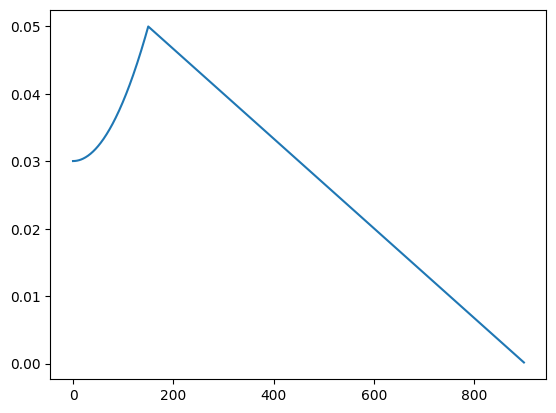

In [557]:
from matplotlib import pyplot as plt

LRS = []
w = n_epochs//5
for epoch in range(w + n_epochs):
    lr = LR(epoch, w)
    LRS.append(lr)
    
plt.plot(LRS)
plt.show()

In [509]:
n_epochs


750

array([ 9.58208697e-01,  8.85045484e-01,  8.22448926e-01,  7.67748490e-01,
        7.19173390e-01,  6.75488908e-01,  6.35799712e-01,  5.99435848e-01,
        5.65882915e-01,  5.34737352e-01,  5.05676715e-01,  4.78439297e-01,
        4.52809768e-01,  4.28608828e-01,  4.05685593e-01,  3.83911887e-01,
        3.63177902e-01,  3.43388854e-01,  3.24462352e-01,  3.06326335e-01,
        2.88917412e-01,  2.72179523e-01,  2.56062850e-01,  2.40522928e-01,
        2.25519900e-01,  2.11017902e-01,  1.96984549e-01,  1.83390498e-01,
        1.70209077e-01,  1.57415973e-01,  1.44988959e-01,  1.32907666e-01,
        1.21153377e-01,  1.09708855e-01,  9.85581914e-02,  8.76866730e-02,
        7.70806640e-02,  6.67275044e-02,  5.66154181e-02,  4.67334336e-02,
        3.70713114e-02,  2.76194806e-02,  1.83689822e-02,  9.31141755e-03,
        4.38903000e-04, -8.25597164e-03, -1.67801802e-02, -2.51402936e-02,
       -3.33425106e-02, -4.13926852e-02])

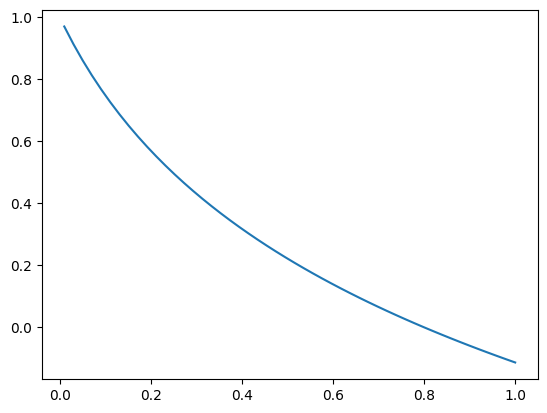

In [589]:
plt.plot(X[50:], np.log(X[50:]+0.2)/np.log(0.2))
np.log(X[50:]+0.1)/np.log(0.1)

In [578]:
X[49:]

array([-0.01010101,  0.01010101,  0.03030303,  0.05050505,  0.07070707,
        0.09090909,  0.11111111,  0.13131313,  0.15151515,  0.17171717,
        0.19191919,  0.21212121,  0.23232323,  0.25252525,  0.27272727,
        0.29292929,  0.31313131,  0.33333333,  0.35353535,  0.37373737,
        0.39393939,  0.41414141,  0.43434343,  0.45454545,  0.47474747,
        0.49494949,  0.51515152,  0.53535354,  0.55555556,  0.57575758,
        0.5959596 ,  0.61616162,  0.63636364,  0.65656566,  0.67676768,
        0.6969697 ,  0.71717172,  0.73737374,  0.75757576,  0.77777778,
        0.7979798 ,  0.81818182,  0.83838384,  0.85858586,  0.87878788,
        0.8989899 ,  0.91919192,  0.93939394,  0.95959596,  0.97979798,
        1.        ])

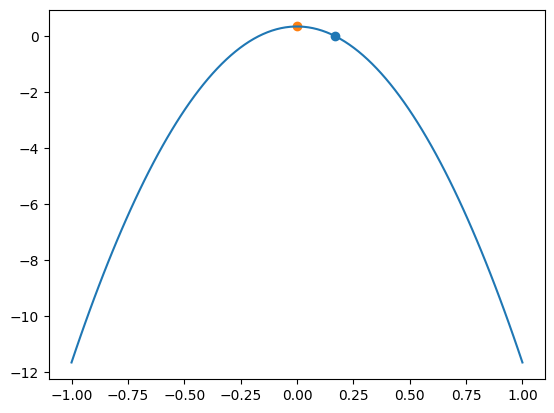

In [421]:
s = 1/6
X = np.linspace(start=-1, stop=1, num=100)
a,c = -2/s, 2*s
plt.plot(X, a*X**2 + c)
'''
0,2s
s,0
y'(0) = 0
'''
plt.scatter(s, 0)
plt.scatter(0, 2*s)

In [ ]:
LR(20)

0.04996629061511783

In [219]:
epoch = 0
x = 0.00001*(epoch - n_epochs)*(epoch + n_epochs//3)
x, np.exp(x)

(-1.8750000000000002, 0.15335496684492844)

In [228]:
err,P, Q = min(Results)

In [229]:
err

24260.458564874774

In [230]:
S = Q@P.T
# S[S<0.1] = 0
R.sum(), S.sum()

(23038.0, 5.50274848510598e+187)

In [231]:
((S - R)**2).sum()

/var/folders/yh/qdnh620s5k713znk3pgdt3cc0000gp/T/ipykernel_18681/989862736.py:1: RuntimeWarning: overflow encountered in square
  ((S - R)**2).sum()


inf

In [180]:
S

array([[8.40264352e-04, 9.53775962e-03, 2.19816347e-02, ...,
        4.89818660e-03, 0.00000000e+00, 3.57073801e-02],
       [2.95356952e-03, 3.97801450e-02, 9.70125893e-02, ...,
        5.56169336e-03, 0.00000000e+00, 2.23987925e-02],
       [6.87431149e-03, 8.17681606e-03, 1.91362465e-02, ...,
        2.01149381e-03, 0.00000000e+00, 1.37233650e-03],
       ...,
       [3.76072380e-02, 2.17582307e-02, 3.73206808e-03, ...,
        3.44750268e-02, 0.00000000e+00, 1.05856548e-03],
       [4.39318665e-02, 8.39499746e-03, 2.20965838e-02, ...,
        9.72355935e-03, 0.00000000e+00, 5.09591702e-03],
       [0.00000000e+00, 4.66961601e-03, 4.29049378e-03, ...,
        4.59272918e-02, 0.00000000e+00, 4.42298363e-06]])

In [169]:
R.nonzero()[0].shape

(23038,)

In [170]:
S.nonzero()[0].shape

(819157,)

In [171]:
S.min(), S.max()

(0.0, 2.2746673154041654)

In [129]:
S[S>1e-4].min()

0.00010000274759089245

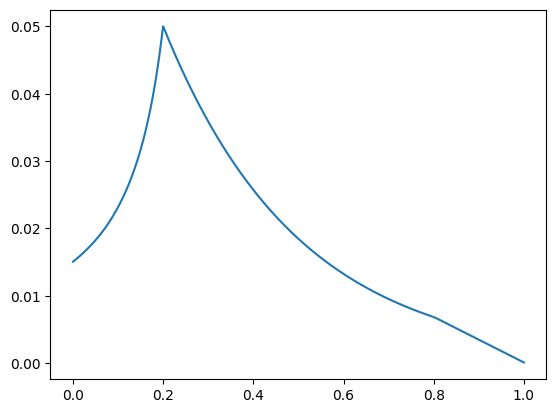

In [1]:
from mf import learning_rate_scheduler
from matplotlib import pyplot as plt
import numpy as np

it = learning_rate_scheduler(2000)
y = list(it)
plt.plot(np.linspace(0, 1, 2000), y)

In [5]:
y[-1]

0.006853230633506978

In [2]:
np.exp(-2.0)

0.1353352832366127

In [2]:
from mf import py_linear_scheduler
it = py_linear_scheduler(10, 0.15, 0.001)
list(it)

[0.1351,
 0.1202,
 0.10529999999999999,
 0.0904,
 0.0755,
 0.0606,
 0.045700000000000005,
 0.030800000000000008,
 0.015900000000000025,
 0.0010000000000000286]

In [1]:
from mf import linear_scheduler
it = linear_scheduler(10, 0.1, 0.0001)
y = list(it)

In [2]:
y

[0.1,
 0.0889,
 0.07780000000000001,
 0.06670000000000001,
 0.055600000000000004,
 0.044500000000000005,
 0.0334,
 0.0223,
 0.011200000000000002,
 0.0001]

In [6]:
from mf import acc_scheduler
it = acc_scheduler(20, 0.0001, 0.1)
y = list(it)


In [7]:
import numpy as np
y = np.array(y)
y[1:] - y[:-1]

array([5.54969168e-06, 6.20186696e-06, 6.97617991e-06, 7.90515934e-06,
       9.03293574e-06, 1.04205880e-05, 1.21546044e-05, 1.43607181e-05,
       1.72274096e-05, 2.10476498e-05, 2.62970824e-05, 3.37901757e-05,
       4.50179773e-05, 6.29569320e-05, 9.42864339e-05, 1.56748070e-04,
       3.12019584e-04, 9.24411656e-04, 9.81335953e-02])

In [10]:
def f():
    for i in it:
        yield i

In [13]:
list(f())

[0.1,
 0.0889,
 0.07780000000000001,
 0.06670000000000001,
 0.055600000000000004,
 0.044500000000000005,
 0.0334,
 0.0223,
 0.011200000000000002,
 0.0001]

In [4]:
from data_reader import read_interaction_matrix
R = read_interaction_matrix()

from mf import matrix_factorization
from matplotlib import pyplot as plt

def get_errors(logs):
    errors = [log[0] for log in logs]
    return errors

q, p, err, logs = matrix_factorization(R, lr=(1e-2,1e-4), n_epochs=2000)
errors = get_errors(logs)
plt.plot(errors)

0.1 0.0001


2it [00:00, 16.71it/s]

err: 2.30e+04, lr: 0.0100899


12it [00:00, 35.69it/s]/Users/aeirya/Documents/ir/information-retrieval-course/hw3/mf.py:23: RuntimeWarning: overflow encountered in matmul
  e = (r - q @ p.T)
/Users/aeirya/Documents/ir/information-retrieval-course/hw3/mf.py:23: RuntimeWarning: invalid value encountered in matmul
  e = (r - q @ p.T)
106it [00:02, 41.18it/s]

err: nan, lr: 0.0736104


122it [00:02, 42.75it/s]


KeyboardInterrupt: 

In [3]:
S = (q@p.T)

def f(f):
    i = 5
    i += 1 if f < 0 else 0
    return str(f)[:i]

[f(x) for x in [S[0,6], S[0,7], S.mean(), S.min(), S.max()]]

['0.034', '0.011', '0.023', '-0.591', '1.610']

In [9]:
import numpy as np

def gen():
    yield "HI"
    return np.arange(10)

for i in gen():
    print(i)

HI


In [4]:
from mf import init_pq

q, p = init_pq(*R.shape, 64)

In [13]:
R[0, 6]

0.0

In [5]:
q.max(), 1/64

(0.29038511840798553, 0.015625)

In [8]:
(R.mean(axis=1) * 733).mean()

17.192537313432837

In [24]:
R.shape

(1340, 733)

In [30]:
import numpy as np
a = np.arange(25).reshape((5,5))

In [31]:
a

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

In [45]:
a[np.array([2,4])[:, None], [2,3,1]]

array([[12, 22],
       [13, 23],
       [11, 21]])

In [18]:
R[R.nonzero()].shape

(23038,)